In [ ]:
# Code based on: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
# and: https://github.com/lcampillos/Medical-NER/blob/master/bert_ner.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
# Load the data

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("/content/drive/MyDrive/.../FR-manual-MT-sents-number.tsv",sep=" ",engine="python",quoting=3)
data.tail(10)

,sentence,text,labels
15199,497,à,O
15200,497,Mme,B-PER
15201,497,Price,I-PER
15202,497,l,O
15203,497,',O
15204,497,autorisation,O
15205,497,de,O
15206,497,faire,O
15207,497,appel,O
15208,497,.,O


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the dataset:
# French corpus of 13 texts from ECHR (automatic translations) with manual annotations

tr_data, val_data = train_test_split(data, random_state=42, test_size=0.2, shuffle=False)

In [ ]:
tr_data.tail(10)

,sentence,text,labels
12157,400,.,I-CODE
12158,400,2,I-CODE
12159,400,",",I-CODE
12160,400,E,I-CODE
12161,400,.,I-CODE
12162,400,1,I-CODE
12163,400,et,O
12164,400,11,B-CODE
12165,400,/,I-CODE
12166,400,23W1E,I-CODE


In [ ]:
test_data, val_data = train_test_split(val_data, random_state=42, test_size=0.5, shuffle=False)

In [ ]:
test_data.tail(10)

,sentence,text,labels
13678,449,la,O
13679,449,Commission,O
13680,449,de,O
13681,449,clarifier,O
13682,449,sa,O
13683,449,position,O
13684,449,et,O
13685,449,de,O
13686,449,tenir,O
13687,449,une,O


In [ ]:
val_data.tail(10)

,sentence,text,labels
15199,497,à,O
15200,497,Mme,B-PER
15201,497,Price,I-PER
15202,497,l,O
15203,497,',O
15204,497,autorisation,O
15205,497,de,O
15206,497,faire,O
15207,497,appel,O
15208,497,.,O


In [ ]:
print(len(tr_data))
print(len(val_data))
print(len(test_data))

12167
1521
1521


In [ ]:
class ProcessSentences(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["text"].values.tolist(),
                                                           s["labels"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
sentences_data_train = ProcessSentences(tr_data)
sentences_data_dev = ProcessSentences(val_data)
sentences_data_test = ProcessSentences(test_data)

In [ ]:
sentences_train = [[word[0] for word in sentence] for sentence in sentences_data_train.sentences]
sentences_dev = [[word[0] for word in sentence] for sentence in sentences_data_dev.sentences]
sentences_test = [[word[0] for word in sentence] for sentence in sentences_data_test.sentences]
sentences_dev[0][:10] # First 10 elements of sentence 1

['audience', ',', 'le', 'requérant', 'a', 'mis', 'en', 'cause', 'l', "'"]

In [ ]:
# Show labels
labels_train = [[s[1] for s in sentence] for sentence in sentences_data_train.sentences]
labels_dev = [[s[1] for s in sentence] for sentence in sentences_data_dev.sentences]
labels_test = [[s[1] for s in sentence] for sentence in sentences_data_test.sentences]
print(labels_dev[0][:10]) # First 10 labels of sentence 1

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# Label values
tag_values = list(set(tr_data["labels"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

Apply mBERT

In [ ]:
!pip install torch

In [ ]:
# Prepare the sentences and labels

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences

torch.__version__

'2.1.0+cu118'

In [ ]:
# Bert supports sequences of up to 512 tokens

MAX_LEN = 250
bs = 32

In [ ]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
!nvidia-smi

Wed Nov 29 16:39:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model_checkpoint = 'bert-base-multilingual-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_checkpoint, do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# Function to tokenize and preserve labels
def tokenize_and_keep_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize each word and count number of its subwords
        # We force conversion to string to avoid errors with float elements
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # The tokenized word is added to the resulting tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # The same label is added to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels_train = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

In [ ]:
tokenized_texts_and_labels_dev = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_dev, labels_dev)
]

In [ ]:
tokenized_texts_and_labels_test = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

In [ ]:
tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

tokenized_texts_dev = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_dev]
labels_dev = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_dev]

tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]

In [ ]:
# Padding of sentences according to desired input length
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_dev],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
# Paddding of labels with regard to input length
tags_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_dev = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_dev],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
# Create the attention mask to ignore the padded elements in the sequences during training, development and testing
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [ ]:
# Convert the dataset to torch tensors
train_inputs = torch.tensor(input_ids_train)
dev_inputs = torch.tensor(input_ids_dev)
test_inputs = torch.tensor(input_ids_test)
train_tags = torch.tensor(tags_train)
dev_tags = torch.tensor(tags_dev)
test_tags = torch.tensor(tags_test)
train_masks = torch.tensor(attention_masks_train)
dev_masks = torch.tensor(attention_masks_dev)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
# We define the dataloaders.
# Shuffle the data for training using RandomSampler
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Load dev and test data sequentially with SequentialSampler.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

Fit mBERT for named entity recognition

In [ ]:
# Setup the Bert model for finetuning

import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.35.2'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Pass the model parameters to the GPU

model.cuda();

In [ ]:
# weight_decay is a regularization procedure with regard to the weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

# Adam optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Import a scheduler to reduce the learning rate
from transformers import get_linear_schedule_with_warmup

# Number of training epochs; the BERT paper uses 4
epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# Define some metrics

!pip install seqeval==0.0.12

  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7414 sha256=900adbbcbe8410d0bfb56c2e2da78ba9004e205c0d11cfeceaf766c2796d40a2
  Stored in directory: /root/.cache/pip/wheels/6c/6c/fc/7076d687ba54f32c7be7eaaded97df359ef3c8fee08a2d4efc
Successfully built seqeval


In [ ]:
import seqeval
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

In [ ]:
%%time
# To measure execution time of this cell

# Train the model for; the BERT paper uses 4
## Store the average loss after each epoch; these values are used to plot the loss.
loss_values, development_loss_values = [], []

for _ in range(epochs):
    #
    # Training
    #
    # Set the model into training mode
    model.train()
    # Reset the total loss for each epoch
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Transfer batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Remove previous gradients before each backward pass
        model.zero_grad()
        # forward pass
        # This returns the loss (not the model output) since we have input the labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Backward pass to compute the gradients
        loss.backward()
        # Train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))


    # Store each loss value for plotting the learning curve afterwards
    loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on development set

    # Set the model into evaluation mode
    model.eval()
    # Reset the development loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # The model must not compute or save gradients, in order to save memory and speed up this step
        with torch.no_grad():
            # Forward pass, compute predictions
            # This will return the logits (logarithm of the odds), not the loss (we do not provide labels)
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Transfer logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute the accuracy for this batch of development sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    dev_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Development Accuracy: {}".format(accuracy_score(pred_tags, dev_tags)))
    print("Development F1-Score: {}".format(f1_score(pred_tags, dev_tags)))
    print("Development Precision: {}".format(precision_score(pred_tags, dev_tags)))
    print("Development Recall: {}".format(recall_score(pred_tags, dev_tags)))
    print("Development classification report:\n{}".format(classification_report(pred_tags, dev_tags))) # digits=4
    print()

Average train loss: 1.206128824215669
Development loss: 0.28593164682388306
Development Accuracy: 0.257360959651036
Development F1-Score: 0
Development Precision: 0.0
Development Recall: 0.0
Development classification report:
           precision    recall  f1-score   support

      PAD       0.00      0.00      0.00       219

micro avg       0.00      0.00      0.00       219
macro avg       0.00      0.00      0.00       219


Average train loss: 0.1713120834185527
Development loss: 0.09662498906254768
Development Accuracy: 0.8729552889858233
Development F1-Score: 0
Development Precision: 0.0
Development Recall: 0.0
Development classification report:
           precision    recall  f1-score   support

      PAD       0.00      0.00      0.00        29

micro avg       0.00      0.00      0.00        29
macro avg       0.00      0.00      0.00        29


Average train loss: 0.08456934845218292
Development loss: 0.062018249183893204
Development Accuracy: 0.920392584514722
Development

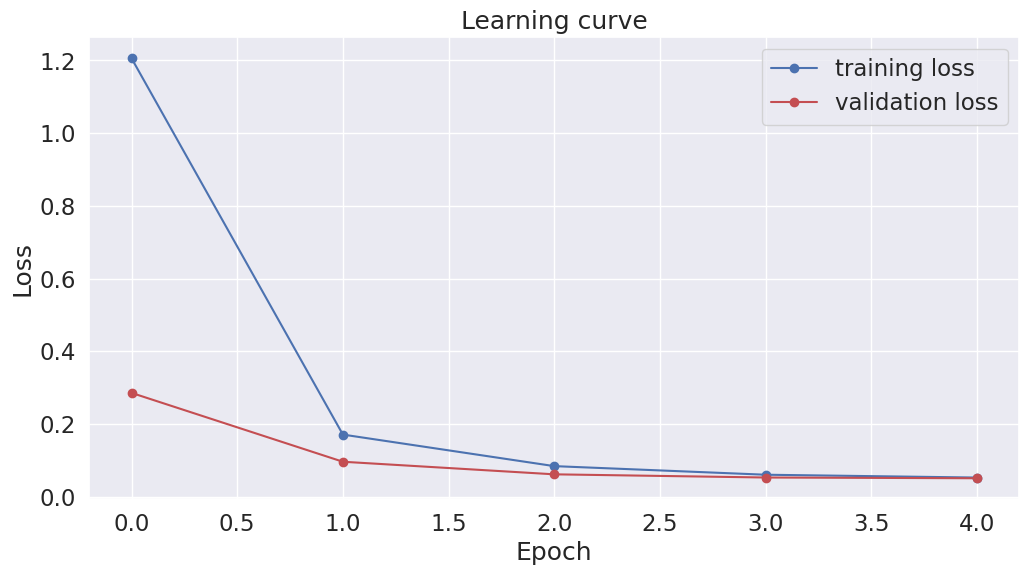

In [ ]:
# Plot the training loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
# Apply the model to the test set
# Set again the model into evaluation mode
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

input_ids_list = []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # The model must not compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate predictions.
        outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
    # Transfer logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)

    # Calculate the accuracy for this batch of test sentences
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
test_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
print("Test Accuracy: {}".format(accuracy_score(pred_tags, test_tags),digits=4))
print("Test F1-Score: {}".format(f1_score(pred_tags, test_tags)))
print("Test Precision: {}".format(precision_score(pred_tags, test_tags)))
print("Test Recall: {}".format(recall_score(pred_tags, test_tags)))
print("Test classification report: {}".format(classification_report(pred_tags, test_tags))) #digits=4
print()

Test Accuracy: 0.9685977260422306
Test F1-Score: 0.5542168674698795
Test Precision: 0.48936170212765956
Test Recall: 0.6388888888888888
Test classification report:                     precision    recall  f1-score   support

              DATE       0.83      0.79      0.81        19
               LOC       0.58      0.58      0.58        12
LEGAL_PROFESSIONAL       0.25      0.25      0.25         4
               PER       0.00      0.00      0.00         1

         micro avg       0.49      0.64      0.55        36
         macro avg       0.66      0.64      0.65        36




In [ ]:
# Apply the model to a new sentence

test_sentence = """
Le Tribunal de Washington va juger M. Trump à partir du 4 mars 2024.
"""

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	Le
O	Tribunal
O	de
O	Washington
O	va
O	juger
O	M
I-PER	.
PAD	Trump
O	à
O	partir
O	du
I-DATE	4
I-DATE	mars
I-DATE	2024
O	.
PAD	[SEP]


In [ ]:
# Save model

path = '/content/drive/MyDrive/...'

torch.save(model, path)

In [ ]:
# Load model

# model = torch.load(path)